<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/TEST_graphsage_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install optuna
!pip install joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.9/583.9 kB 37.1 MB/s eta 0:00:00


In [2]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.4/500.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.3/210.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Evaluation Metrics (GraphSAGE):
RMSE: 77228330222796128.000000
MAE: 5964214925524992.000000
TM-Score: 0.829977
RMSD: 77228322345451520.000000


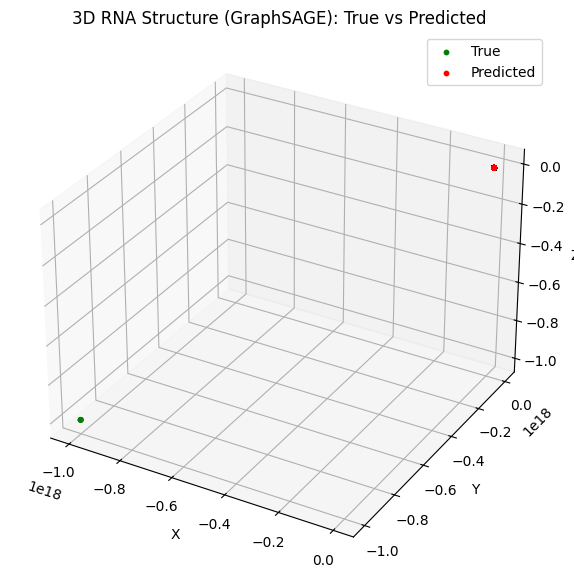

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch.nn import Linear
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load data
seq_df = pd.read_csv("/kaggle/validation_sequences.csv")
label_df = pd.read_csv("/kaggle/validation_labels.csv")

# Preprocessing
label_df['resname'] = label_df['resname'].str.extract(r'([AUGC])')
label_df = label_df.dropna(subset=['resname'])
label_df['target_id'] = label_df['ID'].str.extract(r'(.+)_\d+')
merged = pd.merge(label_df, seq_df[['target_id', 'sequence']], on='target_id', how='left')
residue_mapping = {'A': 0, 'U': 1, 'G': 2, 'C': 3}

def create_graph(df_group):
    df_group = df_group.sort_values('resid')
    sequence = df_group['sequence'].values[0]
    coords = df_group[['x_1', 'y_1', 'z_1']].values

    node_features = torch.eye(4)[[residue_mapping[r] for r in df_group['resname']]]
    pos = torch.tensor(coords, dtype=torch.float)
    y = pos.clone()

    n = len(df_group)
    edge_index = torch.tensor(
        [[i, i+1] for i in range(n-1)] + [[i+1, i] for i in range(n-1)],
        dtype=torch.long
    ).t().contiguous()

    return Data(x=node_features, edge_index=edge_index, pos=pos, y=y)

val_graphs = [create_graph(merged[merged['target_id'] == tid]) for tid in merged['target_id'].unique()]
val_loader = DataLoader(val_graphs, batch_size=1)

# Define GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(input_dim=4, hidden_dim=32, output_dim=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Graphsage_Model.pth", map_location=device))
model.eval()

# Predict
predictions, true_coords = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        pred = model(batch)
        predictions.append(pred.cpu().numpy())
        true_coords.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_coords = np.concatenate(true_coords, axis=0)

# Metrics
rmse = np.sqrt(mean_squared_error(true_coords, predictions))
mae = mean_absolute_error(true_coords, predictions)

def calculate_tm_score(true, pred):
    d = np.linalg.norm(true - pred, axis=1)
    N = true.shape[0]
    return np.mean(np.exp(-d / (0.5 * N)))

def calculate_rmsd(true, pred):
    return np.sqrt(np.mean((true - pred) ** 2))

tm_score = calculate_tm_score(true_coords, predictions)
rmsd = calculate_rmsd(true_coords, predictions)

print("\nEvaluation Metrics (GraphSAGE):")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"TM-Score: {tm_score:.6f}")
print(f"RMSD: {rmsd:.6f}")

# 3D Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], c='g', label='True', s=10)
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], c='r', label='Predicted', s=10)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('3D RNA Structure (GraphSAGE): True vs Predicted')
ax.legend()
plt.show()


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Then save it to your drive
torch.save(model.state_dict(), '/content/drive/MyDrive/GCNConv_Model.pth')
joblib.dump(scaler, '/content/drive/MyDrive/GCNConc_Scaler.save')

print("Saved to Google Drive as 'GCNConv_Model.pth'")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved to Google Drive as 'GCNConv_Model.pth'
